In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import math

In [3]:
np.random.seed(100)
N = 500 # number of data points

In [4]:
t = np.linspace(0, 4*np.pi, N)
# t = t/(max(t))
data = 15.0*np.sin(t+0.001) + 0.05 + np.random.randn(N) # create artificial data with noise
# data = 3.0*np.sin(t+100) 

In [5]:
df= pd.DataFrame({'X1':t, 'Y':data})

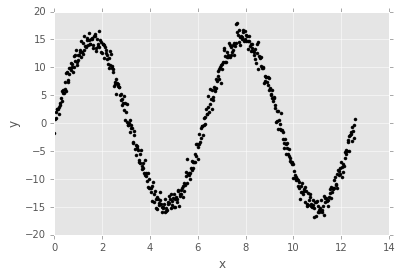

In [6]:
def plot_data(data =df):
    plt.plot(data['X1'],data['Y'],'k.')
    plt.xlabel('x')
    plt.ylabel('y')

plot_data()

In [7]:
def polynomial_data(data, power =1):
    tmp_df = pd.DataFrame()
    col_degree = ['X'+str(i) for i in range(1,power+1)]
    
    for i in range(1,power+1):
        tmp_df[col_degree[i-1]]=df['X1']**i
        
    return tmp_df

In [8]:
#5 degree polynomial
# df_poly = pd.concat([polynomial_data(df,5), df['Y']], axis=1)

In [9]:
#n degree polynomial
df_poly = pd.concat([polynomial_data(df,5), df['Y']], axis=1)

In [10]:
df_poly.head()

,X1,X2,X3,X4,X5,Y
0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.684765
1,0.025183,0.000634,0.000016,4.021956e-07,1.012853e-08,0.785382
2,0.050366,0.002537,0.000128,6.435129e-06,3.241131e-07,1.973190
3,0.075549,0.005708,0.000431,3.257784e-05,2.461234e-06,0.944683
4,0.100732,0.010147,0.001022,1.029621e-04,1.037162e-05,2.554676


In [12]:
import h2o
h2o.init(min_mem_size='2G')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 min 22 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,3 months and 27 days !!!
H2O cluster name:,H2O_from_python_user_czgjh9
H2O cluster total nodes:,1
H2O cluster free memory:,1.917 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [13]:
hdf= h2o.H2OFrame(df_poly)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [16]:
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)

In [17]:
input_name= hdf.col_names
input_name.remove('Y')
print input_name

[u'X1', u'X2', u'X3', u'X4', u'X5']


In [19]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator


In [26]:
# from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator


In [29]:
nfolds =5
my_gbm = H2OGradientBoostingEstimator(ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x = input_name, y = 'Y', training_frame=hdf_train, validation_frame=hdf_validate)

# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x = input_name, y = 'Y', training_frame=hdf_train, validation_frame=hdf_validate)



# Train a stacked ensemble using the GBM and GLM above
# ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
#                                        base_models=[my_gbm.model_id, my_rf.model_id])
# ensemble.train(x = input_name, y = 'Y', training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [58]:
dl0 = H2ODeepLearningEstimator(seed =10,hidden =[200, 200], epochs =100,l2=1e-55, model_id='dl10')

In [42]:
response = 'Y'
base_model=['my_gbm', 'my_rf']
level_one_data= hdf_train[response]

level_one_data = level_one_data.cbind(my_gbm.predict(hdf_train))
level_one_data = level_one_data.cbind(my_rf.predict(hdf_train))

x = level_one_data.col_names
x.remove(response)

level_one_data_test, level_one_data_valid = level_one_data.split_frame([0.75])

dl0.train(x = x, y = response, training_frame=level_one_data_test, validation_frame=level_one_data_valid)



gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [62]:
def get_level_one_data(base_model=[my_gbm, my_rf], response = 'Y'):
    level_one_data= hdf_train[response]
    
    for i in base_model:
        level_one_data = level_one_data.cbind(i.predict(hdf_train))
        
    return level_one_data

In [63]:
level_one_data= get_level_one_data()

gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [65]:
x = level_one_data.col_names
x.remove(response)

level_one_data_test, level_one_data_valid = level_one_data.split_frame([0.75])

dl0.train(x = x, y = response, 
                          training_frame=level_one_data_test, validation_frame=level_one_data_valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [56]:
# def esemble_prediction(base_model=[my_gbm, my_rf], meta_learner = dl0, response = 'Y'):
    
#     level_one_data= hdf_train[response]
    
#     for i in base_model:
#         level_one_data = level_one_data.cbind(i.predict(hdf_train))
    
# #     level_one_data = level_one_data.cbind(my_rf.predict(hdf_train))

#     x = level_one_data.col_names
#     x.remove(response)

#     level_one_data_test, level_one_data_valid = level_one_data.split_frame([0.75])

#     model = (meta_learner.train(x = x, y = response, 
#                               training_frame=level_one_data_test, validation_frame=level_one_data_valid))
#     model.predict(level_one_data_valid)
    

In [66]:
# ensembel_model = esemble_prediction()

In [55]:
type(ensembel_model)

NoneType

deeplearning Model Build progress: |████

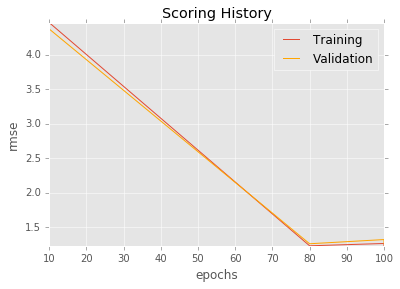

In [67]:
dl0.plot()

In [68]:
print 'train mse: ', dl0.mse(train=True)
print 'valid mse: ', dl0.mse(valid=True)

train mse:  1.52478217823
valid mse:  1.5986021354


In [96]:
# model = h2o.estimators.deeplearning(x=input_name, y='Y', training_frame=hdf_train, validation_frame=hdf_validate,
#                                     distribution="multinomial", activation="RectifierWithDropout", 
#                                     hidden=[10,10,10], input_dropout_ratio=0.2, l1=1e-5, epochs=10)


deeplearning prediction progress: |███████████████████████████████████████| 100%


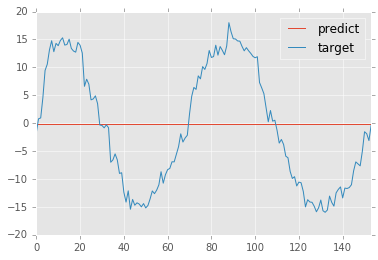

In [75]:
prediction= dl0.predict(hdf_validate)

prediction['target']=hdf_validate['Y']
output= prediction.as_data_frame()
output.plot()

Y
2.55468
3.945
5.7045
5.49193
7.3207
7.70263
10.8545
11.1781
13.06
10.4085
